In [1]:
ls

__init__.py   configs.py   local_run.ipynb  trainer.py
__pycache__/  evaluate.py  main.py


In [1]:
cd ../../

/nndl


In [2]:
import numpy as np

In [3]:
import argparse
import json
from pathlib import Path
import torch

from src.training.configs import TrainingConfig
from src.training.trainer import (
    build_dataloaders,
    build_model,
    build_optimizer,
    build_scheduler,
    Trainer,
    EarlyStopper,
)
from src.utils.logging import save_metrics
from src.utils.seed import set_seed
from src.visualization.plot_confidence_distribution import plot_conf_hist_with_quantiles

from torch.utils.data import ConcatDataset,DataLoader

### Set-up

In [4]:
from types import SimpleNamespace

args = SimpleNamespace(**{
    "mode": "clip_b32",
    "train_csv": "data/splits/train_split.csv",
    "val_csv": "data/splits/val_split.csv",
    "calib_csv": "data/splits/calibration_split.csv",
    "images_root": "data/raw/train_images",
    "far_ood_root": "data/raw/farood_images",
    "superclass_map": "data/meta/superclass_mapping.csv",
    "subclass_map": "data/meta/subclass_mapping.csv",
    "num_super": 4,
    "num_sub": 88,
    "lambda_sub": 1.0,
    "batch_size": 64,
    "num_epochs": 15,
    "epochs_finetune": 10,
    "patience": 3,
    "fine_tune": False,
    "optimizer": "adamw",
    "optimizer_finetune": "adamw",
    "scheduler": "none",
    "scheduler_finetune": "cosine",
    "lr": 3e-4,
    "lr_finetune": 3e-5,
    "num_workers": 4,
    "save_dir": "checkpoints",
    "seed": 42,
})

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(args.seed)

cfg = TrainingConfig(
    mode=args.mode,
    backbone=None if args.mode == "baseline" else args.mode,
    train_csv=args.train_csv,
    val_csv=args.val_csv,
    calib_csv=args.calib_csv,
    images_root=args.images_root,
    far_ood_root=args.far_ood_root,
    superclass_map=args.superclass_map,
    subclass_map=args.subclass_map,
    batch_size=args.batch_size,
    num_epochs=args.num_epochs,
    epochs_finetune=args.epochs_finetune,
    patience=args.patience,
    lr=args.lr,
    lr_finetune=args.lr_finetune,
    fine_tune=args.fine_tune,
    lambda_sub=args.lambda_sub,
    num_super=args.num_super,
    num_sub=args.num_sub,
    num_workers=args.num_workers,
    save_dir=f"{args.save_dir}/{args.mode}",
    seed=args.seed,
    optimizer=args.optimizer,
    optimizer_finetune=args.optimizer_finetune,
    scheduler=None if args.scheduler == "none" else args.scheduler,
    scheduler_finetune=None if args.scheduler_finetune == "none" else args.scheduler_finetune,
)

In [6]:
print("building dataloaders...")
train_loader, val_loader, calib_loader, near_ood_loader, far_ood_loader = build_dataloaders(cfg)

def collate_ignore_meta(batch):
    images, y_super, y_sub, _ = zip(*batch)
    return (
        torch.stack(images),
        torch.tensor(y_super),
        torch.tensor(y_sub),
        None,   # meta dropped
    )
    
open_set_dataset = ConcatDataset([
    val_loader.dataset,
    near_ood_loader.dataset,
    far_ood_loader.dataset,
])

open_set_loader = DataLoader(
    open_set_dataset,
    batch_size=val_loader.batch_size,
    shuffle=False,
    num_workers=val_loader.num_workers,
    collate_fn=collate_ignore_meta,
)

building dataloaders...


### Train Dual-Head

In [7]:
model = build_model(cfg).to(device)

trainer = Trainer(
    model=model,
    criterion=torch.nn.CrossEntropyLoss(),
    optimizer=None,  # set per phase
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    lambda_sub=cfg.lambda_sub,
    patience=cfg.patience,
)

# Stage 1: baseline or frozen backbone head training
trainer.optimizer = build_optimizer(cfg.optimizer, model.parameters(), cfg.lr)
trainer.scheduler = build_scheduler(cfg.scheduler, trainer.optimizer, cfg.num_epochs)

stopper = EarlyStopper(cfg.patience)

save_dir = Path(cfg.save_dir)
save_dir.mkdir(parents=True, exist_ok=True)
best_head_path = save_dir / "best_head.pth"

trainer.fit(
    cfg.num_epochs,
    "Epoch",
    stopper,
    best_head_path
)

[Epoch 00] train_loss=4.8959, val_loss=4.1200, val_super_acc=0.9989, val_sub_acc=0.3962


[Epoch 01] train_loss=3.6544, val_loss=3.2733, val_super_acc=1.0000, val_sub_acc=0.5667


[Epoch 02] train_loss=2.9498, val_loss=2.7116, val_super_acc=1.0000, val_sub_acc=0.6292


[Epoch 03] train_loss=2.4516, val_loss=2.2961, val_super_acc=1.0000, val_sub_acc=0.6896


[Epoch 04] train_loss=2.0777, val_loss=1.9764, val_super_acc=1.0000, val_sub_acc=0.7288


[Epoch 05] train_loss=1.7900, val_loss=1.7309, val_super_acc=1.0000, val_sub_acc=0.7754


[Epoch 06] train_loss=1.5636, val_loss=1.5326, val_super_acc=1.0000, val_sub_acc=0.8019


[Epoch 07] train_loss=1.3844, val_loss=1.3755, val_super_acc=1.0000, val_sub_acc=0.8189


[Epoch 08] train_loss=1.2386, val_loss=1.2484, val_super_acc=1.0000, val_sub_acc=0.8305


[Epoch 09] train_loss=1.1178, val_loss=1.1446, val_super_acc=1.0000, val_sub_acc=0.8443


[Epoch 10] train_loss=1.0187, val_loss=1.0514, val_super_acc=1.0000, val_sub_acc=0.8496


[Epoch 11] train_loss=0.9345, val_loss=0.9777, val_super_acc=1.0000, val_sub_acc=0.8538


[Epoch 12] train_loss=0.8623, val_loss=0.9153, val_super_acc=1.0000, val_sub_acc=0.8676


[Epoch 13] train_loss=0.8013, val_loss=0.8582, val_super_acc=1.0000, val_sub_acc=0.8708


[Epoch 14] train_loss=0.7473, val_loss=0.8108, val_super_acc=1.0000, val_sub_acc=0.8750


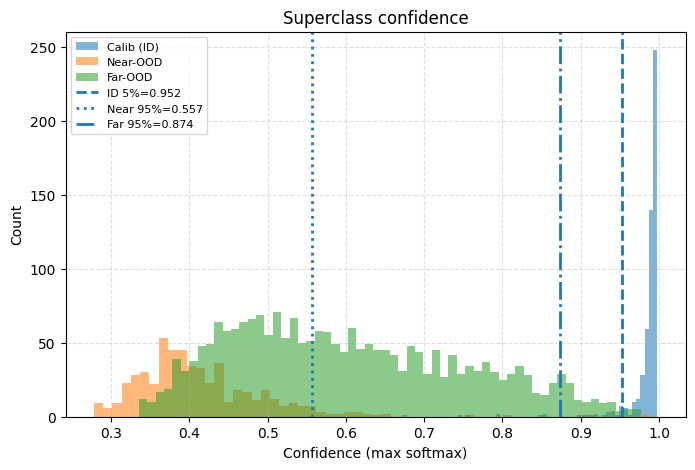

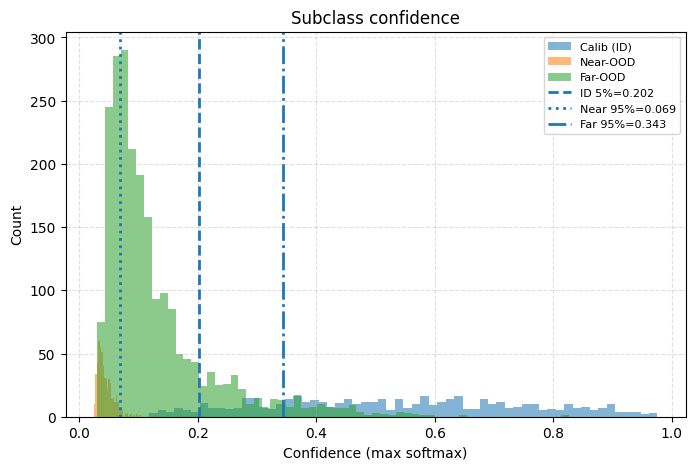

In [8]:
calib_sup, calib_sub = trainer._collect_confidence(calib_loader)
near_ood_sup, near_ood_sub = trainer._collect_confidence(near_ood_loader)
far_ood_sup, far_ood_sub = trainer._collect_confidence(far_ood_loader)

plot_conf_hist_with_quantiles(calib_sup, near_ood_sup, far_ood_sup, "Superclass confidence")
plot_conf_hist_with_quantiles(calib_sub, near_ood_sub, far_ood_sub, "Subclass confidence")

In [9]:
trainer.calibrate(calib_loader, far_ood_loader)

{'tau_super': 0.9128381013870239, 'tau_sub': 0.2725990414619446}

In [10]:
trainer.evaluate_open_set(open_set_loader)

{'ce_super': 2.992990887962391,
 'ce_sub': 5.676273027537244,
 'super_overall': 98.42305600870039,
 'super_seen': 98.51694915254237,
 'super_unseen': 98.390636430139,
 'sub_overall': 94.18162044589451,
 'sub_seen': 77.96610169491525,
 'sub_unseen': 99.7805413313826}

In [11]:
trainer.evaluate_open_set(val_loader)

{'ce_super': 0.014300877765073614,
 'ce_sub': 0.7965009050854182,
 'super_overall': 98.51694915254237,
 'super_seen': 98.51694915254237,
 'super_unseen': 0.0,
 'sub_overall': 77.96610169491525,
 'sub_seen': 77.96610169491525,
 'sub_unseen': 0.0}

### Fine Tune

In [12]:
for p in model.backbone.parameters():
    p.requires_grad = True

trainer.optimizer = build_optimizer(cfg.optimizer_finetune, model.parameters(), cfg.lr_finetune)
trainer.scheduler = build_scheduler(cfg.scheduler_finetune, trainer.optimizer, cfg.epochs_finetune)

stopper = EarlyStopper(cfg.patience)

best_ft_path = save_dir / "best_finetune.pth"

print("Start Fine Tuning...")
trainer.fit(
    cfg.epochs_finetune,
    "Tune",
    stopper,
    best_ft_path
)

Start Fine Tuning...


[Tune 00] train_loss=0.3814, val_loss=0.2400, val_super_acc=1.0000, val_sub_acc=0.9258


[Tune 01] train_loss=0.1212, val_loss=0.1812, val_super_acc=1.0000, val_sub_acc=0.9439


[Tune 02] train_loss=0.0384, val_loss=0.1226, val_super_acc=0.9989, val_sub_acc=0.9597


[Tune 03] train_loss=0.0132, val_loss=0.1081, val_super_acc=1.0000, val_sub_acc=0.9682


[Tune 04] train_loss=0.0058, val_loss=0.1007, val_super_acc=1.0000, val_sub_acc=0.9661


[Tune 05] train_loss=0.0044, val_loss=0.0985, val_super_acc=1.0000, val_sub_acc=0.9672


[Tune 06] train_loss=0.0038, val_loss=0.0968, val_super_acc=1.0000, val_sub_acc=0.9661


[Tune 07] train_loss=0.0035, val_loss=0.0970, val_super_acc=1.0000, val_sub_acc=0.9661


[Tune 08] train_loss=0.0033, val_loss=0.0968, val_super_acc=1.0000, val_sub_acc=0.9661


[Tune 09] train_loss=0.0032, val_loss=0.0967, val_super_acc=1.0000, val_sub_acc=0.9661


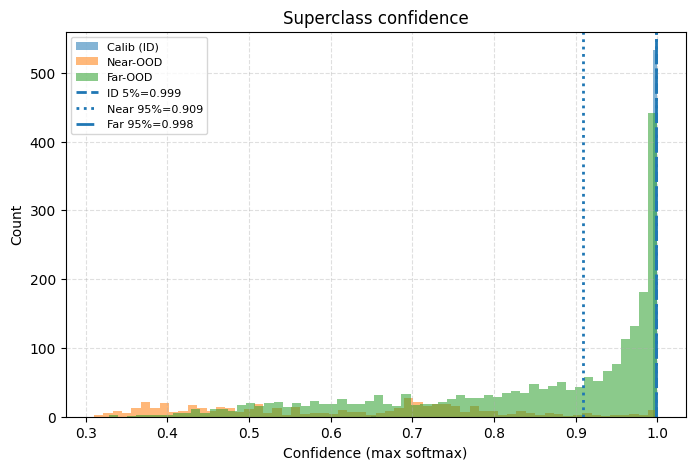

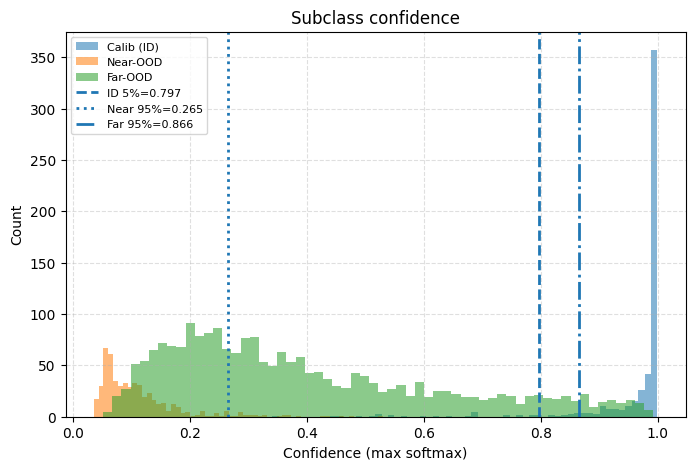

In [13]:
calib_sup, calib_sub = trainer._collect_confidence(calib_loader)
near_ood_sup, near_ood_sub = trainer._collect_confidence(near_ood_loader)
far_ood_sup, far_ood_sub = trainer._collect_confidence(far_ood_loader)

plot_conf_hist_with_quantiles(calib_sup, near_ood_sup, far_ood_sup, "Superclass confidence")
plot_conf_hist_with_quantiles(calib_sub, near_ood_sub, far_ood_sub, "Subclass confidence")

In [57]:
trainer.calibrate(calib_loader, far_ood_loader)

{'tau_super': 0.9985768795013428, 'tau_sub': 0.8311777710914612}

In [58]:
trainer.evaluate_open_set(open_set_loader)

{'ce_super': 3.417926218415357,
 'ce_sub': 5.286330314678236,
 'super_overall': 96.60141381185427,
 'super_seen': 97.88135593220339,
 'super_unseen': 96.15947329919531,
 'sub_overall': 97.06362153344209,
 'sub_seen': 90.14830508474576,
 'sub_unseen': 99.45135332845648}

### Generate Test Label

In [59]:
import importlib
import src.data.dataset as dataset_mod

importlib.reload(dataset_mod)

from src.data.dataset import TestDataset
from src.data.transforms import get_eval_transform

test_ds = TestDataset(
    images_root="data/raw/test_images",
    transform=get_eval_transform(),
    superclass_mapping_path=cfg.superclass_map,
    subclass_mapping_path=cfg.subclass_map)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=cfg.num_workers,
)

In [60]:
len(test_loader)

11180

In [28]:
from tqdm import tqdm
import torch
from src.utils.const import NOVEL_SUPER_IDX, NOVEL_SUB_IDX

trainer.model.eval()

imgs = []
sup_preds = []
sub_preds = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Test", leave=False)

    for image, image_name in pbar:
        image = image.to(trainer.device)

        logits_super, logits_sub = trainer.model(image)

        probs_super = torch.softmax(logits_super, dim=1)
        probs_sub   = torch.softmax(logits_sub, dim=1)

        conf_super, pred_super = probs_super.max(dim=1)
        conf_sub, pred_sub     = probs_sub.max(dim=1)

        # Open-set rejection
        pred_super[conf_super < trainer.tau_super] = NOVEL_SUPER_IDX
        pred_sub[conf_sub < trainer.tau_sub] = NOVEL_SUB_IDX

        # Hierarchical constraint
        pred_sub[pred_super == NOVEL_SUPER_IDX] = NOVEL_SUB_IDX

        imgs.extend(image_name)
        sup_preds.append(pred_super.cpu())
        sub_preds.append(pred_sub.cpu())

# Final tensors (N,)
sup_preds = torch.cat(sup_preds)
sub_preds = torch.cat(sub_preds)

In [29]:
import pandas as pd

df = pd.DataFrame({
    "image": [f"{i}.jpg" for i in range(len(sup_preds))],
    "superclass_index": sup_preds.numpy(),
    "subclass_index": sub_preds.numpy(),
})

df.to_csv("test_predictions2.csv", index=False)

In [71]:
df

,image,superclass_index,subclass_index
0,0.jpg,1,87
1,1.jpg,3,87
2,2.jpg,2,34
3,3.jpg,3,87
4,4.jpg,1,87
...,...,...,...
11175,11175.jpg,3,87
11176,11176.jpg,3,87
11177,11177.jpg,3,87
11178,11178.jpg,3,87


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


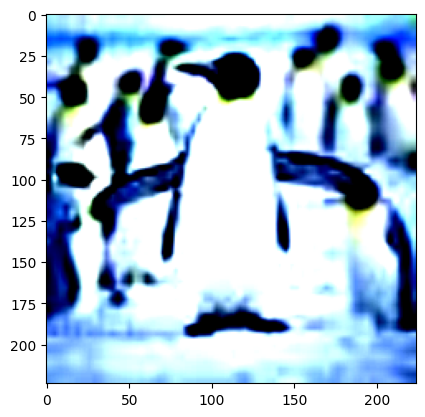

In [75]:
for images, names in test_loader:
    if names[0] == "9500.jpg":
        break

import matplotlib.pyplot as plt
plt.imshow(images[0].permute(1, 2, 0).numpy())
plt.show()

In [72]:
df.iloc[9500]

image               9500.jpg
superclass_index           0
subclass_index            20
Name: 9500, dtype: object

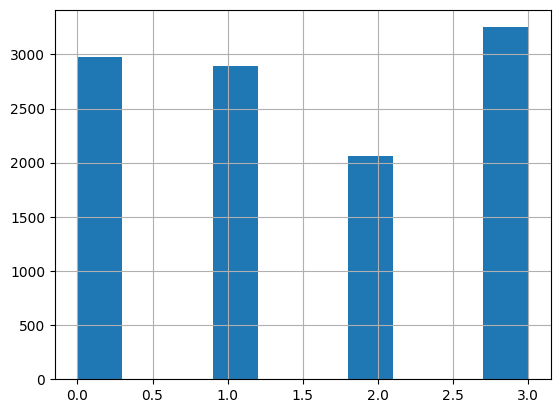

In [73]:
df['superclass_index'].hist()
plt.show()

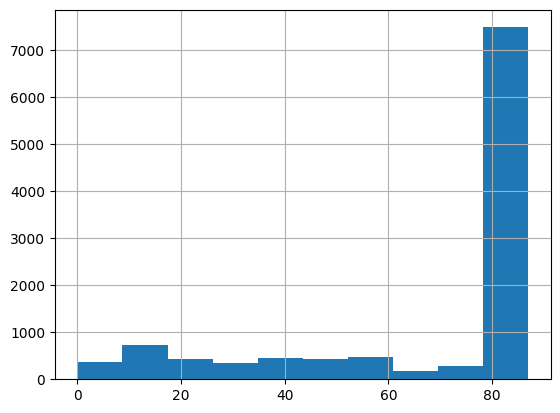

In [74]:
df['subclass_index'].hist()
plt.show()